In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [2]:
# Script definitions
# ------------------

# DAXPY - data_1.csv
# Histogram_1 - data_2.csv
# Histogram_2 - data_3.csv

data_file = '../../lab2/data/data_2.csv'
images_dir = '../images/histogram_1'

fixed_image = './images/grayscale_by_cols.pgm'


In [3]:
# Create the output directory if it doesn't exist
if not os.path.exists(images_dir):

	os.mkdir(images_dir)

else :

	os.system("rm -r " + images_dir)
	os.mkdir(images_dir)

In [4]:
# Load the data into a pandas DataFrame
data = pd.read_csv(data_file, sep=',', header=None)

# Add column names to the DataFrame
# DAXPY - printf("PAE,%d,%d,%d,%f,%f,%f,%f,%f,%f,%ld,%f,PAE\n", threadsPerBlock, blocksPerGrid, maxBlocksPerSM, occupancy, overhead, alloc_time, init_time, daxpy_time, total_time, n, alpha);
# Histogram - printf("\nPAE,%s,%d,%d,%d,%f,%f,%f,%f,%f,%f,%f,%f,%ld,PAE\n", imagePath, threadsPerBlock, blocksPerGrid, maxBlocksPerSM, occupancy, overhead, alloc_time, init_time, histogram_time, hd_time, dh_time, total_time, imageSize);

data.columns = ['imagePath', 'threadsPerBlock', 'blocksPerGrid', 'maxBlocksPerSM', 'occupancy', 'overhead', 'alloc_time', 'init_time', 'histogram_time', 'hd_time', 'dh_time', 'total_time', 'imageSize']

# Print total number of rows and columns in the DataFrame
print("Total rows: {0}".format(len(data)))

Total rows: 330


In [5]:
data = data[data['overhead'] < 0.1]

print("Total rows: {0}".format(len(data)))

Total rows: 330


In [6]:
data_filtered = data[data['imagePath'] == fixed_image]

df_filtered = data_filtered[['threadsPerBlock', 'occupancy', 'histogram_time']]

df_max_occupancy = df_filtered[df_filtered['occupancy'] == 1.0]

grouped = df_max_occupancy.groupby('threadsPerBlock')['histogram_time'].mean()

min_histogram_time = grouped.idxmin()

print("Threads per block to get min daxpy time with full occupancy: {0}".format(min_histogram_time))

Threads per block to get min daxpy time with full occupancy: 128


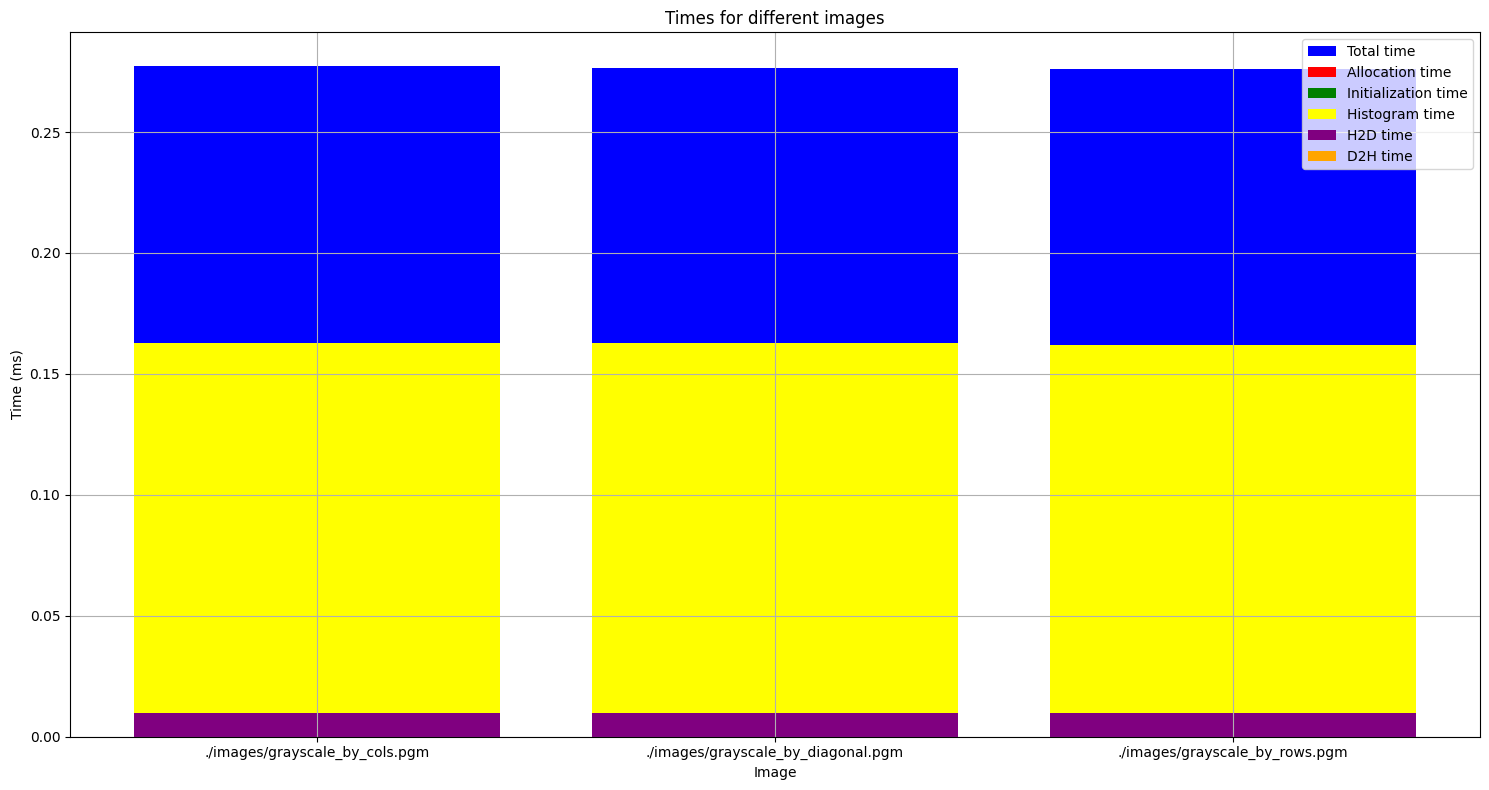

In [8]:
new_data = data[data['threadsPerBlock'] == 256]

mean_alloc_time = new_data.groupby('imagePath')['alloc_time'].mean()
mean_init_time = new_data.groupby('imagePath')['init_time'].mean()
mean_histogram_time = new_data.groupby('imagePath')['histogram_time'].mean()
mean_hd_time = new_data.groupby('imagePath')['hd_time'].mean()
mean_dh_time = new_data.groupby('imagePath')['dh_time'].mean()
mean_total_time = new_data.groupby('imagePath')['total_time'].mean()

plt.figure(figsize=(15, 8))

plt.bar(mean_total_time.index, mean_total_time, color='blue', label='Total time')
plt.bar(mean_alloc_time.index, mean_alloc_time, color='red', label='Allocation time')
plt.bar(mean_init_time.index, mean_init_time, color='green', label='Initialization time')
plt.bar(mean_histogram_time.index, mean_histogram_time, color='yellow', label='Histogram time')
plt.bar(mean_hd_time.index, mean_hd_time, color='purple', label='H2D time')
plt.bar(mean_dh_time.index, mean_dh_time, color='orange', label='D2H time')

plt.xlabel('Image')
plt.ylabel('Time (ms)')

plt.title('Times for different images')

plt.legend()
plt.grid()
plt.tight_layout()

plt.savefig(images_dir + '/execution_times.png')

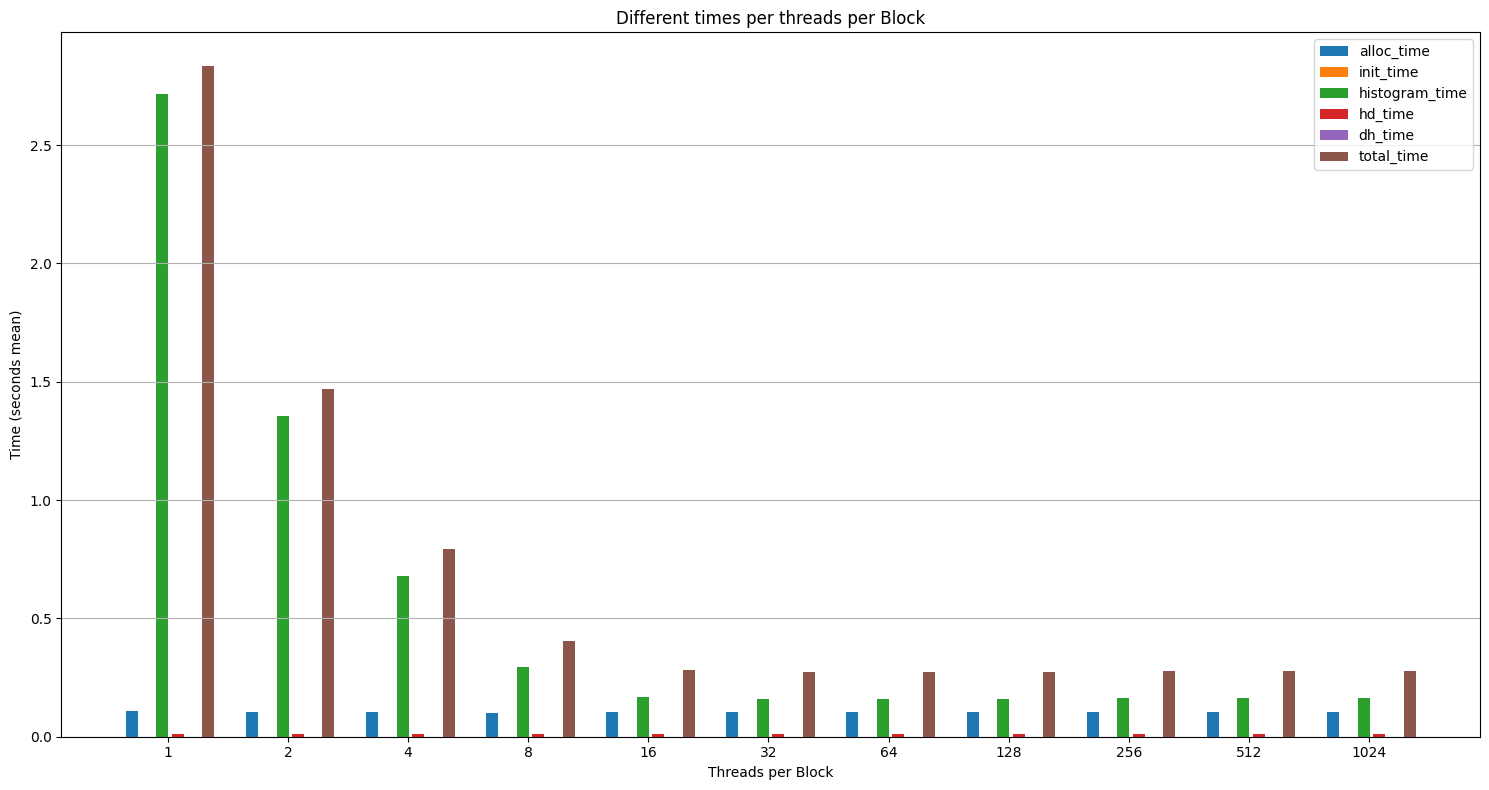

In [ ]:
# Bar plot with all diferent times per threadsPerBlock unique values
# -----------------------------------------------------------------

data_filtered = data[data['imagePath'] == fixed_image]

unique_threadsPerBlock = data_filtered['threadsPerBlock'].unique()
n_groups = len(unique_threadsPerBlock)
metrics = ['alloc_time', 'init_time', 'histogram_time', 'hd_time', 'dh_time', 'total_time']
n_metrics = len(metrics)
bar_width = 0.1
index = np.arange(n_groups)

plt.figure(figsize=(15, 8))

for j, metric in enumerate(metrics):

	means = [data_filtered[data_filtered['threadsPerBlock'] == tp][metric].mean() for tp in unique_threadsPerBlock]
	plt.bar(index + j * bar_width * 1.275, means, bar_width, label=metric)

plt.xlabel('Threads per Block')
plt.ylabel('Time (seconds mean)')

plt.xticks(index + bar_width * (n_metrics / 2), unique_threadsPerBlock)

plt.title('Different times per threads per Block')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

plt.savefig(os.path.join(images_dir, 'times_per_threadsPerBlock.png'))

plt.show()

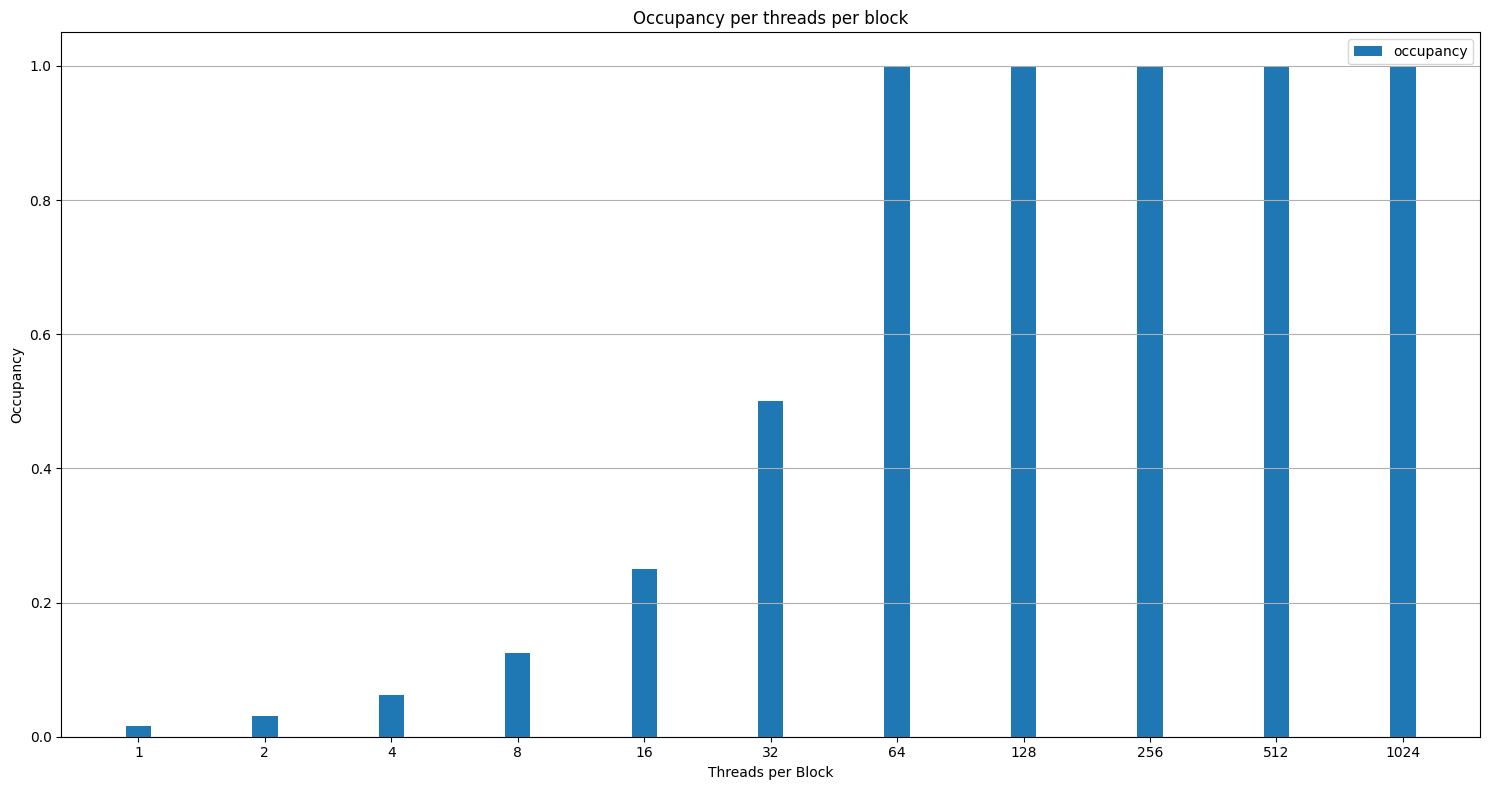

In [ ]:

data_filtered = data[data['imagePath'] == fixed_image]

unique_threadsPerBlock = data_filtered['threadsPerBlock'].unique()
n_groups = len(unique_threadsPerBlock)
metrics = ['occupancy']
n_metrics = len(metrics)

bar_width = 0.2
index = np.arange(n_groups)

plt.figure(figsize=(15, 8))

for j, metric in enumerate(metrics):

	means = [data_filtered[data_filtered['threadsPerBlock'] == tp][metric].mean() for tp in unique_threadsPerBlock]
	plt.bar(index + j * bar_width, means, bar_width, label=metric)

plt.xlabel('Threads per Block')
plt.ylabel('Occupancy')
plt.xticks(index, unique_threadsPerBlock)

plt.title('Occupancy per threads per block')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

plt.savefig(os.path.join(images_dir, 'occupancy_per_threadsPerBlock.png'))

plt.show()

In [ ]:
finalData = []

data_filtered = data

min_process = data_filtered['threadsPerBlock'].min()

ref_dataset = data_filtered[data_filtered['threadsPerBlock'] == min_process]

ref_times = ref_dataset.groupby('imagePath')['histogram_time'].max()

for (image_value, threads_value), group in data_filtered.groupby(['imagePath', 'threadsPerBlock']):

	max_compute_time = group['histogram_time'].max()
	max_total_time = group['total_time'].max()

	ref_time = ref_times.get(image_value, None)

	speedup = ref_time / max_compute_time
	efficiency = speedup / threads_value

	# Secuential daxpy time 0.8514 seconds and total time 4.3128s
	# Histogram - 0.2045 seconds and 0.6341 seconds

	secuential_compute_speedup = 0.2045/ max_compute_time
	secuential_total_speedup = 0.6341 / max_total_time

	quality = 1 / max_compute_time

	finalData.append([threads_value, image_value, max_compute_time, ref_time, speedup, efficiency, quality, secuential_compute_speedup, secuential_total_speedup])

final_df = pd.DataFrame(finalData, columns=['threads', 'imagePath', 'MaxTime', 'RefTime', 'Speedup', 'Efficiency', 'Quality', 'SecuentialComputeSpeedup', 'SecuentialTotalSpeedup'])

display(final_df)

# Generate table latex code for the final_df DataFrame fixed to 2 decimal places
# final_df.to_latex(os.path.join(images_dir, 'final_df.tex'), index=False, float_format="%.2f")

,threads,imagePath,MaxTime,RefTime,Speedup,Efficiency,Quality,SecuentialComputeSpeedup,SecuentialTotalSpeedup
0,1,./images/grayscale_by_cols.pgm,2.720857,2.720857,1.000000,1.000000,0.367531,0.075160,0.219524
1,2,./images/grayscale_by_cols.pgm,1.357256,2.720857,2.004675,1.002337,0.736781,0.150672,0.427042
2,4,./images/grayscale_by_cols.pgm,0.678800,2.720857,4.008334,1.002084,1.473188,0.301267,0.797770
3,8,./images/grayscale_by_cols.pgm,0.293306,2.720857,9.276515,1.159564,3.409410,0.697224,1.556275
4,16,./images/grayscale_by_cols.pgm,0.168246,2.720857,16.171929,1.010746,5.943690,1.215485,2.224502
5,32,./images/grayscale_by_cols.pgm,0.159896,2.720857,17.016418,0.531763,6.254066,1.278957,2.299746
6,64,./images/grayscale_by_cols.pgm,0.161614,2.720857,16.835541,0.263055,6.187588,1.265362,2.269645
7,128,./images/grayscale_by_cols.pgm,0.161643,2.720857,16.832485,0.131504,6.186465,1.265132,2.276495
8,256,./images/grayscale_by_cols.pgm,0.162889,2.720857,16.703757,0.065249,6.139154,1.255457,2.252082
9,512,./images/grayscale_by_cols.pgm,0.163327,2.720857,16.658989,0.032537,6.122700,1.252092,2.091505


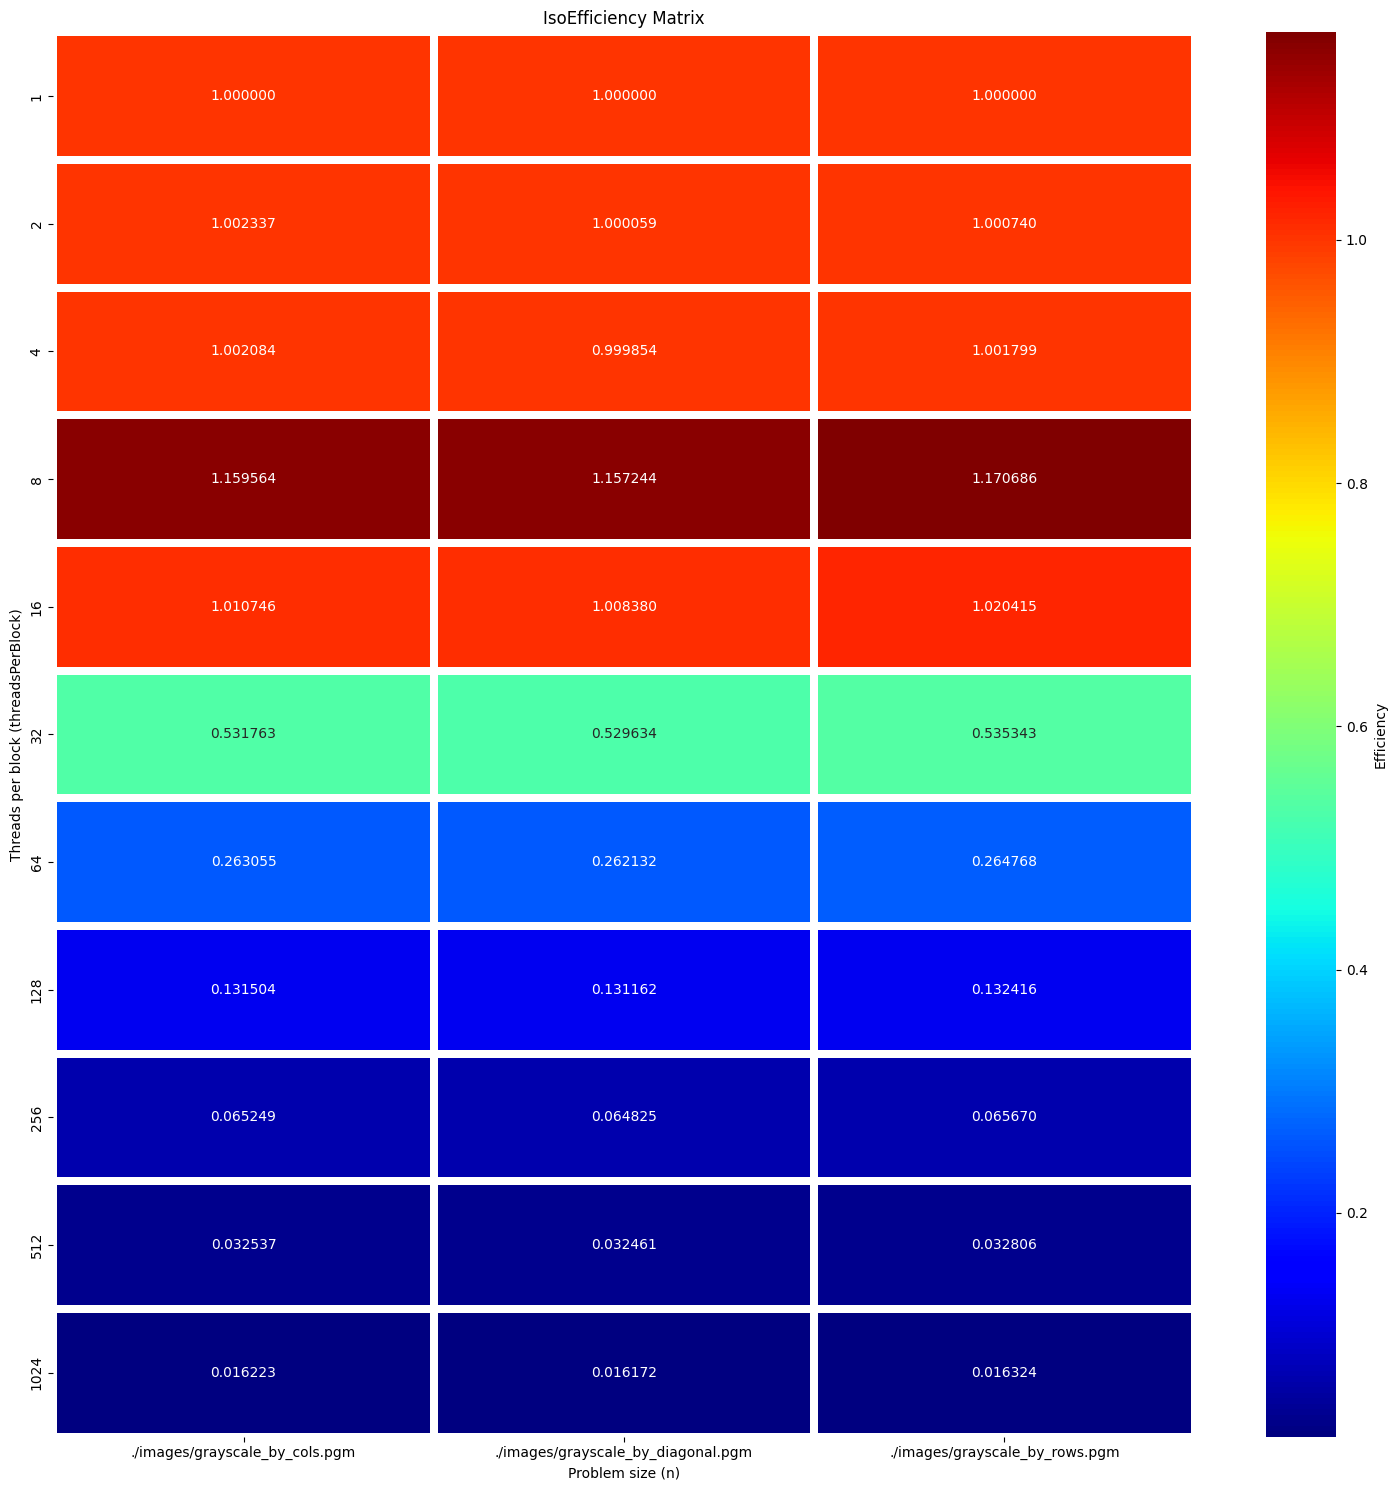

In [ ]:
efficiency_matrix = final_df.pivot(index='threads', columns='imagePath', values='Efficiency')

plt.figure(figsize=(15, 15))

ax = sns.heatmap(efficiency_matrix, annot=True, fmt=".6f", cmap='jet', cbar_kws={'label': 'Efficiency'}, linewidths=4.5, linecolor='white')

ax.set_title("IsoEfficiency Matrix")
ax.set_xlabel("Problem size (n)")
ax.set_ylabel("Threads per block (threadsPerBlock)")

plt.tight_layout()

plt.savefig(os.path.join(images_dir, 'isoEfficiencyMatrix.png'))

plt.show()